## COMP9321 25T3 Assignment 1 v1.1 (15 marks)

Airbnb is an online platform that allows hosts to advertise stays on the Airbnb website. The New York-based Housing Justice Data Lab maintains public datasets to help understand Airbnb's impact on residential communities.

This assignment uses modified Airbnb data for Sydney:

- `listings.csv`: Listing information to help people book stays.
- `reviews.csv`: Review data from guests, including comments and reviewer info.
- `neighbourhoods.geojson`: Geographic boundary data for Sydney neighbourhoods.

You can download all files in a zip file from: [https://drive.google.com/file/d/1ICB0P593g90gJZAd-Lyy4dKrjJ1reHJ_/view?usp=sharing]

### Assignment Instructions

Failure to follow these rules may result in penalties during marking.

#### Environment Setup
- Use the provided `requirements.txt` to set up your virtual environment.
- Use only libraries available in the virtual environment (e.g., `pandas`, `matplotlib`).
- Use Python **3.13** only.

#### Your Answers!
In this assignment you will need to provide three types of answers as explained in each question:
- Dataframe/Table as an output
    - Use the code cell [https://jupyter-notebook.readthedocs.io/en/stable/notebook.html#code-cells] where you see **# YOUR CODE GOES HERE**. If the last line of your code is the result dataframe, the notebook will automatically display the results.
- Plots (visualisations)
   - Use the code cell [https://jupyter-notebook.readthedocs.io/en/stable/notebook.html#code-cells] where you see **# YOUR CODE GOES HERE**. For plots/images you need to have **plt.show()** as the last line of your code.
- Explanation
  - Use the markdown cell [https://jupyter-notebook.readthedocs.io/en/stable/notebook.html#markdown-cells] .

#### Coding Standards
- Do **not** use `for` or `while` loops over DataFrame rows or Series.
- Do **not** convert DataFrames to native Python types (`list`, `dict`) for processing.
- Plots/Dataframes answering the questions must be shown in the notebook output. For each question, there must be ONLY a single code cell to answer each question and its output should reflect your answer. You must make sure you include all outputs before subbmitting your notebook file.
- Do **not** modify the provided code template structure; instead add your code where indicated by "YOUR CODE GOES HERE"
- You may write helper functions inside the code cell for the question where it is used.
- Pandas Operations- Your solutions should leverage efficient native Pandas operations (such as apply, drop, read_csv, etc.) rather than manual or iterative approaches. Additionally, ensure that DataFrames are properly indexed and sorted to enhance readability and facilitate easier data exploration. Finally, code efficiency and cleanliness are part of the marking critria.

#### Visualisation Standards
For questions 4, 5, and 6 make sure you:
- Choose a suitable chart type for the data.
- Use appropriate scale and colour.
- Include title, axis labels, and legend with readable sizing.
- Ensure the visualisation is self-explanatory and informative.
- You may use sub-plots inside one window to fit multiple visualisations.
#### Submission
- You can use WebCMS to submit your notebook file which should be named **zid.ipynb** (e.g., z123456.ipynb). You only need to submit the notebook file.
- Make sure you include all the outputs in the notebook file (run all cells before submisoion) otherwise you will be penalised by 50% of the question.
- Late submission is allowed with 5% penalty per day - You can submit no later than 5 days late.
- Link for submission: [https://webcms3.cse.unsw.edu.au/COMP9321/25T3/resources/114681]

## Run this prior to your question blocks.

In [38]:
# Make sure you copy the dataset files to the same directory as your notbook
import pandas as pd
import geopandas as gpd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patheffects as pe
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')
listings_df = pd.read_csv('listings.csv')
reviews_df = pd.read_csv('reviews.csv')
neighbourhoods_df = gpd.read_file('neighbourhoods.geojson')

# Question 1 (3 marks)

You need to clean both the **listings_df** and **reviews_df**  dataframes by applying best data wrangling practices. Included, but not limited to, checking for missing values, unexpected data types, removing unnecessary columns, setting proper index, and any obvious data quality issues. It is part of the assignment to explore the dataset and the assignment requirements (including all questions) and clean the dataset as much as you can.  

**Marking Criteria**
- [2 marks]  Properly cleaned dataframes using pandas operations.
- [1 mark]   Properly list all of the steps and why the step is required for a cleaned dataset - comments in the code.


In [39]:
# YOUR CODE GOES HERE - Clean the listings dataframe, name it (listings_df) and show the dataframe as output of your cell
# Normalise column names in listings.csv
def normalise_columns(df):
    """Convert all column names to lowercase with underscores and remove spaces."""
    df.columns = (
        df.columns
        .str.strip()
        .str.lower()
        .str.replace(' ', '_')
        .str.replace('__', '_')
        .str.replace('_$', '', regex=True)
    )
    return df

listings_df = normalise_columns(listings_df)

# Drop necessary columns 
drop_columns = [
    'listing_url', 'scrape_id', 'last_scraped', 'source', 'neighborhood_overview',
    'picture_url', 'host_url', 'host_location', 'host_thumbnail_url', 'host_picture_url',
    'host_neighbourhood', 'host_listings_count', 'host_has_profile_pic',
    'bathrooms_text', 'availability_60', 'availability_90', 'calendar_last_scraped',
    'number_of_reviews_l30d', 'availability_eoy', 'number_of_reviews_ly', 'license'
]
listings_df.drop(columns=[c for c in drop_columns if c in listings_df.columns], inplace=True)

# Handle missing values and format
for possible in ['host_name_', 'host_name_1', 'host_name ', 'host name']:
    if possible in listings_df.columns:
        listings_df.rename(columns={possible: 'host_name'}, inplace=True)
# Fill missing text fields
listings_df['description'] = listings_df['description'].fillna('NA')

# Fill numeric fields with median
for col in ['bathrooms', 'bedrooms', 'beds']:
    if col in listings_df.columns:
        median_val = listings_df[col].median()
        listings_df[col].fillna(median_val, inplace=True)
        print(f"Filled missing values in '{col}' with median: {median_val}")

# Convert date columns to datetime
for col in ['host_since', 'first_review', 'last_review']:
    if col in listings_df.columns:
        listings_df[col] = pd.to_datetime(listings_df[col], errors='coerce')

# Clean and convert price column
if 'price' in listings_df.columns:
    listings_df['price'] = (
        listings_df['price']
        .replace('[\$,]', '', regex=True)
        .astype(float)
    )
    listings_df['price'] = listings_df.groupby('neighbourhood_cleansed')['price'].transform(
    lambda x: x.fillna(x.median())
)

# Fix categorical fields
def weighted_fill(series):
    """Fill NaNs using weighted sampling from existing value proportions."""
    probs = series.value_counts(normalize=True)
    n_missing = series.isna().sum()
    if n_missing > 0 and len(probs) > 0:
        series.loc[series.isna()] = np.random.choice(probs.index, size=n_missing, p=probs.values)
    return series

# Apply weighted filling for categorical variables
for col in ['host_response_time', 'host_is_superhost', 'host_identity_verified']:
    if col in listings_df.columns:
        listings_df[col] = weighted_fill(listings_df[col])

# Convert % fields to numeric
for rate_col in ['host_response_rate', 'host_acceptance_rate']:
    if rate_col in listings_df.columns:
        listings_df[rate_col] = (
            listings_df[rate_col]
            .astype(str)
            .str.replace('%', '', regex=False)
            .replace('nan', np.nan)
            .astype(float)
        )
        listings_df[rate_col].fillna(listings_df[rate_col].median(), inplace=True)

# Convert instant_bookable → boolean
if 'instant_bookable' in listings_df.columns:
    listings_df['instant_bookable'] = (
        listings_df['instant_bookable']
        .astype(str)              # ensure string type
        .str.strip()              # remove whitespace
        .str.lower()              # To lowercase
        .map({'t': True, 'f': False})
    )

print("Completed categorical cleaning.")

# Keep required columns
keep_columns = [
    'id', 'name', 'description', 'host_name', 'host_since', 'host_about',
    'host_response_time', 'host_response_rate', 'host_acceptance_rate', 'host_is_superhost',
    'neighbourhood_cleansed', 'latitude', 'longitude', 'host_total_listings_count',
    'host_verifications', 'host_identity_verified', 'accommodates', 'room_type',
    'property_type', 'bathrooms', 'bedrooms', 'amenities', 'beds', 'price',
    'minimum_nights', 'maximum_nights', 'minimum_nights_avg_ntm', 'maximum_nights_avg_ntm',
    'availability_30', 'availability_365', 'number_of_reviews', 'number_of_reviews_ltm',
    'estimated_occupancy_l365d', 'first_review', 'last_review', 'estimated_revenue_l365d',
    'review_scores_rating', 'review_scores_accuracy', 'review_scores_cleanliness',
    'review_scores_communication', 'review_scores_location', 'review_scores_value',
    'reviews_per_month', 'instant_bookable', 'calculated_host_listings_count'
]
listings_df = listings_df[[c for c in keep_columns if c in listings_df.columns]]

# Final clean-up  and validation
possible_ids = ['id', 'listing_id', 'listingid']
existing_id_col = next((c for c in possible_ids if c in listings_df.columns), None)
if existing_id_col and existing_id_col != 'id':
    listings_df.rename(columns={existing_id_col: 'id'}, inplace=True)
elif 'id' not in listings_df.columns:
    listings_df['id'] = np.arange(len(listings_df))

listings_df.drop_duplicates(subset=['id'], inplace=True)
listings_df.reset_index(drop=True, inplace=True)

print("Data Cleaning Completed")
print(f"Listings Shape: {listings_df.shape}")
# Do not change the following line of code (this will print the dataframe as an output after running the cell)
listings_df

Filled missing values in 'bathrooms' with median: 1.0
Filled missing values in 'bedrooms' with median: 2.0
Filled missing values in 'beds' with median: 2.0
Completed categorical cleaning.
Data Cleaning Completed
Listings Shape: (16793, 45)


,id,name,description,host_name,host_since,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,...,estimated_revenue_l365d,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_communication,review_scores_location,review_scores_value,reviews_per_month,instant_bookable,calculated_host_listings_count
0,1.115600e+04,An Oasis in the City,Very central to the city which can be reached ...,colleen,2009-09-23,"Recently retired, I've lived & worked on 4 con...",a few days or more,100.0,97.0,f,...,0.0,4.59,4.76,4.30,4.76,4.82,4.71,1.02,False,1
1,1.525300e+04,Unique Designer Rooftop Apartment in City Loca...,You will be staying in a unique apartment on t...,morag,2009-12-03,I am originally Scottish but I have made Sydne...,within an hour,100.0,99.0,f,...,25245.0,4.54,4.64,4.51,4.75,4.76,4.56,3.81,True,1
2,4.454500e+04,Sunny Darlinghurst Warehouse Apartment,Sunny warehouse/loft apartment in the heart of...,atari,2010-04-22,Curious about the world and full of wanderlust...,within an hour,100.0,86.0,f,...,5880.0,4.88,4.89,4.84,4.96,4.93,4.79,0.46,False,1
3,5.850600e+04,"Studio Yindi @ Mosman, Sydney","An open plan apartment, adjacent to a spacious...",john,2010-11-06,Faber est suae quisquae fortunae\r\n\r\nWe bec...,within a few hours,100.0,92.0,t,...,34368.0,4.64,4.72,4.35,4.92,4.76,4.73,2.54,False,1
4,6.899900e+04,A little bit of Sydney - Australia,"Hello Everyone,<br /><br />We have a quiet are...",bryan,2011-01-03,We are living in Sydney. We like to see Wine r...,within an hour,100.0,89.0,t,...,7848.0,4.97,4.97,4.99,4.99,4.85,4.93,0.70,False,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16788,1.436620e+18,The Healing Hideaway,Welcome to The Serene Stay in Seven Hills! A p...,sreekala,2015-07-21,NaN,within an hour,100.0,97.0,f,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,1
16789,1.436660e+18,Urban Elegance in Alexandria with Parking,Escape to a piece of history with a stay in ou...,angela,2013-12-05,Air Design Australia Property Management is Ow...,within an hour,100.0,98.0,t,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,23
16790,1.436680e+18,Zetland精美2B2B,This stylish place to stay is perfect for grou...,ethan,2023-11-17,NaN,within a few hours,89.0,93.0,f,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,35
16791,1.436700e+18,Stylish Stay in Chippendale,Looking for a hassle-free stay in Chippendale?...,liuwanwan,2025-05-23,NaN,within an hour,100.0,60.0,f,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,11


In [40]:
# YOUR CODE GOES HERE - Clean the reviews dataframe, name it (reviews_df) and show the dataframe as output of your cell
# Normalise column names in reviews.csv
def normalise_columns(df):
    """Convert all column names to lowercase with underscores and remove spaces."""
    df.columns = (
        df.columns
        .str.strip()
        .str.lower()
        .str.replace(' ', '_')
        .str.replace('__', '_')
        .str.replace('_$', '', regex=True)
    )
    return df
reviews_df = normalise_columns(reviews_df)

# If there are two columns literally named 'id'
if reviews_df.columns.duplicated().any():
    # Keep the *first* 'id' (the one from listing_id), drop the duplicate
    reviews_df = reviews_df.loc[:, ~reviews_df.columns.duplicated()]

# If reviews_df still has both 'listing_id' and 'id' at any point
if 'listing_id' in reviews_df.columns and 'id' in reviews_df.columns:
    reviews_df.drop(columns=['id'], inplace=True)
    reviews_df.rename(columns={'listing_id': 'id'}, inplace=True)

# If only listing_id exists, just rename it
elif 'listing_id' in reviews_df.columns and 'id' not in reviews_df.columns:
    reviews_df.rename(columns={'listing_id': 'id'}, inplace=True)

# Drop irrelevant columns (if present)
reviews_drop = ['reviewer_name']
reviews_df.drop(columns=[c for c in reviews_drop if c in reviews_df.columns], inplace=True)

# Ensure date column is in datetime format
if 'date' in reviews_df.columns:
    reviews_df['date'] = pd.to_datetime(reviews_df['date'], errors='coerce')

# Drop duplicates and rows with missing IDs
if 'id' in reviews_df.columns:
    reviews_df.drop_duplicates(inplace=True)
    reviews_df.dropna(subset=['id'], inplace=True)
    
# Clean up comments column (if exists)
if 'comments' in reviews_df.columns:
    reviews_df['comments'] = reviews_df['comments'].fillna('No comment').str.strip()

# Reset index after cleaning
reviews_df.reset_index(drop=True, inplace=True)

print("Reviews dataframe cleaned successfully.")
print("Reviews_df columns:", reviews_df.columns.tolist())

# Do not change the following line of code
reviews_df

Reviews dataframe cleaned successfully.
Reviews_df columns: ['id', 'date', 'reviewer_id', 'comments']


,id,date,reviewer_id,comments
0,11156,2009-12-05,52946,Colleen was friendly and very helpful regardin...
1,11156,2010-03-31,99382,"Great place, centrally located, easy walk to t..."
2,11156,2010-05-14,105797,Colleen is very friendly and helpful. The apar...
3,11156,2010-11-17,259213,Dear Colleen!\r<br/>My friend Diemut from Germ...
4,11156,2010-12-11,273389,"Lovely, interesting chats and very helpful giv..."
...,...,...,...,...
670538,1421572362905165610,2025-06-01,73808465,We stayed at Muugis place over 3 nights and en...
670539,1421572362905165610,2025-06-06,536898889,"Such a lovely place to stay, service was amazi..."
670540,1421572362905165610,2025-06-08,203786095,"Thank you Muggii for your care and kindness, t..."
670541,1421627348236436828,2025-05-22,662525224,Jonny was an excellent host…gave us advice on ...


In [41]:
# do not remove or modify this cell
listings_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16793 entries, 0 to 16792
Data columns (total 45 columns):
 #   Column                          Non-Null Count  Dtype         
---  ------                          --------------  -----         
 0   id                              16793 non-null  float64       
 1   name                            16793 non-null  object        
 2   description                     16793 non-null  object        
 3   host_name                       16627 non-null  object        
 4   host_since                      16789 non-null  datetime64[ns]
 5   host_about                      9860 non-null   object        
 6   host_response_time              16793 non-null  object        
 7   host_response_rate              16793 non-null  float64       
 8   host_acceptance_rate            16793 non-null  float64       
 9   host_is_superhost               16793 non-null  object        
 10  neighbourhood_cleansed          16793 non-null  object        
 11  la

In [42]:
# do not remove or modify this cell
reviews_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 670543 entries, 0 to 670542
Data columns (total 4 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   id           670543 non-null  int64         
 1   date         670543 non-null  datetime64[ns]
 2   reviewer_id  670543 non-null  int64         
 3   comments     670543 non-null  object        
dtypes: datetime64[ns](1), int64(2), object(1)
memory usage: 20.5+ MB


### Interpretation of Results for Question 1 – Data Cleaning 

The raw **listings dataset** originally contained **81 columns**.  
After systematic inspection, **36 columns were removed** because they included:
- **Metadata and URLs** (e.g., `listing_url`, `picture_url`, `host_url`) that provide no analytical insight.  
- **Redundant attributes**, such as duplicate neighbourhood identifiers and host details repeated elsewhere.  
- **Low-value or constant fields** (e.g., licence numbers, update timestamps) that do not contribute to the required business or statistical analysis.

The **final cleaned dataset (45 columns)** preserves only variables essential for downstream tasks (Q2–Q6):
- **Host features:** response behaviour, verification status, total listings.  
- **Location attributes:** neighbourhood, latitude, and longitude.  
- **Pricing and availability:** nightly price, minimum/maximum nights, and availability metrics.  
- **Guest experience indicators:** review counts, review scores, and amenity information.  

#### Handling Missing Data
- **Numeric fields** such as `bathrooms`, `bedrooms`, and `beds` were imputed using their **median values** to preserve central tendency while avoiding distortion by outliers.  
- **Categorical fields** (e.g., `host_response_time`, `host_is_superhost`, `host_identity_verified`) were completed via **vectorized weighted sampling** that respects each category’s existing frequency distribution.  
  This approach relies on **NumPy’s random choice** for efficiency and fairness, without looping over rows or columns.

#### Data Type Normalisation
- All **date columns** (`host_since`, `first_review`, `last_review`) were converted to proper `datetime` objects for temporal analysis.  
- **Price values** were stripped of currency symbols and cast to `float` for numerical computations.  
- Boolean columns such as `instant_bookable` were standardised to `True/False`.

#### Cleaning Reviews Dataset
The **`reviews.csv`** file was similarly standardised:
- Column names were normalised to lowercase with underscores for consistency.  
- The **`reviewer_name`** column was dropped because it adds **no analytical or modelling value**, poses **privacy concerns**, and does not affect the ability to link reviews to listings.  
- Dates were parsed into `datetime` objects, duplicates removed, and IDs cleaned to ensure a reliable merge key with the listings data.

#### Outcome
After cleaning:
- **`listings_df`** → 16 793 rows × 45 columns  
- **`reviews_df`** → 670 542 rows × 4 columns  
Both datasets are now tidy, type-consistent, and fully ready for **merging and further analysis** in subsequent questions.


# Question 2 (2 marks)

Merge the cleaned listings and reviews dataframes into a single DataFrame. Join the result dataframe with the neighbourhoods dataset - the result dataframe should add two extra columns named 'latitude' and 'longitude' which show the centre of the neighbourhood. You should also clean the result dataframe.

**Marking Criteria**
- [1 mark]  Join Listings and Reviews dataframes.
- [1 mark]  Join the result dataframe with the neighbourhoods dataset - the result dataframe should add two columns named 'latitude' and 'longitude' which shows the centre of the neighbourhood. these two columns replaces the existing 'latitude' and 'longitude' in the listings dataframe

In [43]:
neighbourhoods_df

,neighbourhood,neighbourhood_group,geometry
0,Pittwater,None,"MULTIPOLYGON (((151.29614 -33.57292, 151.29618..."
1,Randwick,None,"MULTIPOLYGON (((151.23722 -33.89075, 151.23731..."
2,Waverley,None,"MULTIPOLYGON (((151.28336 -33.86183, 151.28334..."
3,Warringah,None,"MULTIPOLYGON (((151.2114 -33.61521, 151.21157 ..."
4,Lane Cove,None,"MULTIPOLYGON (((151.16634 -33.80621, 151.1665 ..."
5,North Sydney,None,"MULTIPOLYGON (((151.21456 -33.81584, 151.21461..."
6,Bankstown,None,"MULTIPOLYGON (((151.03244 -33.88828, 151.03248..."
7,Canterbury,None,"MULTIPOLYGON (((151.11418 -33.89578, 151.11461..."
8,Strathfield,None,"MULTIPOLYGON (((151.08398 -33.85785, 151.08417..."
9,Auburn,None,"MULTIPOLYGON (((151.07934 -33.82244, 151.07958..."


In [44]:
# YOUR CODE GOES HERE - join all dataframes and name it merged_df
#  Ensure both dataframes share a consistent merge key
if 'listing_id' in reviews_df.columns:
    reviews_df.rename(columns={'listing_id': 'id'}, inplace=True)
print("Listings columns:", listings_df.columns.tolist())
print("Reviews columns:", reviews_df.columns.tolist())

# Merge Listings and Reviews
merged_df = pd.merge(
    listings_df,
    reviews_df,
    on='id',
    how='left'
)

print([col for col in merged_df.columns if col == 'id'])
print(f"Merged listings + reviews: {merged_df.shape}")

# Prepare neighbourhood dataset
# Normalize column names in neighbourhood dataset
neighbourhoods_df.columns = (
    neighbourhoods_df.columns
    .str.strip()
    .str.lower()
    .str.replace(' ', '_')
)

# Extract centroid coordinates from the geometry column
neighbourhoods_df['latitude'] = neighbourhoods_df['geometry'].centroid.y
neighbourhoods_df['longitude'] = neighbourhoods_df['geometry'].centroid.x

# Keep only relevant columns
neigh_centroids = neighbourhoods_df[['neighbourhood', 'latitude', 'longitude']]

# Rename for merging consistency
neigh_centroids.rename(columns={'neighbourhood': 'neighbourhood_cleansed'}, inplace=True)

# Merge neighbourhood coordinates
merged_df = pd.merge(
    merged_df,
    neigh_centroids,
    on='neighbourhood_cleansed',
    how='left'
)

# Replace listing coordinates with neighbourhood centroids
merged_df['latitude'] = merged_df['latitude_y']
merged_df['longitude'] = merged_df['longitude_y']

# Drop redundant columns
merged_df.drop(columns=['latitude_x', 'longitude_x', 'latitude_y', 'longitude_y'], inplace=True)

# Clean up and finalise
merged_df.drop_duplicates(subset=['id'], inplace=True)
merged_df.reset_index(drop=True, inplace=True)

print(f"Final merged dataframe shape: {merged_df.shape}")
merged_df

Listings columns: ['id', 'name', 'description', 'host_name', 'host_since', 'host_about', 'host_response_time', 'host_response_rate', 'host_acceptance_rate', 'host_is_superhost', 'neighbourhood_cleansed', 'latitude', 'longitude', 'host_total_listings_count', 'host_verifications', 'host_identity_verified', 'accommodates', 'room_type', 'property_type', 'bathrooms', 'bedrooms', 'amenities', 'beds', 'price', 'minimum_nights', 'maximum_nights', 'minimum_nights_avg_ntm', 'maximum_nights_avg_ntm', 'availability_30', 'availability_365', 'number_of_reviews', 'number_of_reviews_ltm', 'estimated_occupancy_l365d', 'first_review', 'last_review', 'estimated_revenue_l365d', 'review_scores_rating', 'review_scores_accuracy', 'review_scores_cleanliness', 'review_scores_communication', 'review_scores_location', 'review_scores_value', 'reviews_per_month', 'instant_bookable', 'calculated_host_listings_count']
Reviews columns: ['id', 'date', 'reviewer_id', 'comments']
['id']
Merged listings + reviews: (45518

,id,name,description,host_name,host_since,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,...,review_scores_location,review_scores_value,reviews_per_month,instant_bookable,calculated_host_listings_count,date,reviewer_id,comments,latitude,longitude
0,1.115600e+04,An Oasis in the City,Very central to the city which can be reached ...,colleen,2009-09-23,"Recently retired, I've lived & worked on 4 con...",a few days or more,100.0,97.0,f,...,4.82,4.71,1.02,False,1,2009-12-05,52946.0,Colleen was friendly and very helpful regardin...,-33.889671,151.202739
1,1.525300e+04,Unique Designer Rooftop Apartment in City Loca...,You will be staying in a unique apartment on t...,morag,2009-12-03,I am originally Scottish but I have made Sydne...,within an hour,100.0,99.0,f,...,4.76,4.56,3.81,True,1,2012-02-23,1371491.0,Morag is a helpful easy going host.\r<br/>Her ...,-33.889671,151.202739
2,4.454500e+04,Sunny Darlinghurst Warehouse Apartment,Sunny warehouse/loft apartment in the heart of...,atari,2010-04-22,Curious about the world and full of wanderlust...,within an hour,100.0,86.0,f,...,4.93,4.79,0.46,False,1,2010-10-20,230093.0,To all who choose this location - we can recom...,-33.889671,151.202739
3,5.850600e+04,"Studio Yindi @ Mosman, Sydney","An open plan apartment, adjacent to a spacious...",john,2010-11-06,Faber est suae quisquae fortunae\r\n\r\nWe bec...,within a few hours,100.0,92.0,t,...,4.76,4.73,2.54,False,1,2010-12-29,287371.0,My mother and I had a delightful time at Studi...,-33.829004,151.244547
4,6.899900e+04,A little bit of Sydney - Australia,"Hello Everyone,<br /><br />We have a quiet are...",bryan,2011-01-03,We are living in Sydney. We like to see Wine r...,within an hour,100.0,89.0,t,...,4.85,4.93,0.70,False,1,2011-06-21,591678.0,Brian and Crystal gave me the pleasure of usin...,-33.583619,151.097443
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16788,1.436620e+18,The Healing Hideaway,Welcome to The Serene Stay in Seven Hills! A p...,sreekala,2015-07-21,NaN,within an hour,100.0,97.0,f,...,NaN,NaN,NaN,False,1,NaT,NaN,NaN,-33.741305,150.864258
16789,1.436660e+18,Urban Elegance in Alexandria with Parking,Escape to a piece of history with a stay in ou...,angela,2013-12-05,Air Design Australia Property Management is Ow...,within an hour,100.0,98.0,t,...,NaN,NaN,NaN,False,23,NaT,NaN,NaN,-33.889671,151.202739
16790,1.436680e+18,Zetland精美2B2B,This stylish place to stay is perfect for grou...,ethan,2023-11-17,NaN,within a few hours,89.0,93.0,f,...,NaN,NaN,NaN,False,35,NaT,NaN,NaN,-33.889671,151.202739
16791,1.436700e+18,Stylish Stay in Chippendale,Looking for a hassle-free stay in Chippendale?...,liuwanwan,2025-05-23,NaN,within an hour,100.0,60.0,f,...,NaN,NaN,NaN,False,11,NaT,NaN,NaN,-33.889671,151.202739


### Interpretation of Results for Question 2 – Data Integration 

To prepare the analytical dataset, three data sources were merged:

1. **Listings and Reviews:**  
   The `listings_df` and `reviews_df` were merged using the common key `id`.  
   A *left join* was applied to retain all listings, even those without reviews, ensuring full coverage of available properties.

2. **Neighbourhood Information:**  
   The `neighbourhoods_df` file provided geographic boundaries for each suburb.  
   From its `geometry` column, **centroid coordinates** were extracted to represent the central point of each neighbourhood.  
   These coordinates replaced the listing-level latitude and longitude to ensure spatial consistency and reduce noise from outlier coordinates.

3. **Final Cleaning:**  
   Duplicate rows were removed, and the index was reset.  
   The final merged dataset combines **host, review, and location features** into a single, clean structure for spatial and statistical analysis in subsequent questions.

**Outcome:**  
The merged dataset now integrates Airbnb listings, reviews, and geographic context ready for deeper analysis on pricing, performance, and host behaviour.


# Question 3 (2 marks)
Airbnb wants to better understand how the scale of a host's operation (i.e. the number of listings they manage) affects key business metrics such as pricing, availability, and guest experience — particularly in relation to the amenities they offer.

You are tasked with building a pivot table that summarises host performance per amenity and per host segment.

- Small Portfolio: 1 listing
- Medium Portfolio: 2–5 listings
- Large Portfolio: 6–10 listings
- Enterprise Portfolio: 10+ listings

Using the provided Airbnb dataset, your task is to:
- Focus on a shortlist of key amenities:
    - WiFi, Kitchen, Air conditioning, Heating, TV, Washer, Free parking
- Create a pivot table that shows, for each combination of host segment and amenity:
    - Average nightly price
    - Average availability in the next 30 days
    - Average review score rating

**Marking Criteria**
- [1 mark]  A proper dataframe as an output to fullfil the requirement.
- [1 mark]  Interpretation of your results and justification of your analysis—explain what conclusions you can draw from the results.

In [45]:
# YOUR CODE GOES HERE - your pivot table should be named summary - All of the rows of this table should be shown

# Define host portfolio segments
def segmenting_the_host(n):
    if n == 1:
        return 'Small Portfolio (1 listing)'
    elif 2 <= n <= 5:
        return 'Medium Portfolio (2–5 listings)'
    elif 6 <= n <= 10:
        return 'Large Portfolio (6–10 listings)'
    else:
        return 'Enterprise Portfolio (10+ listings)'

merged_df['host_segments'] = merged_df['calculated_host_listings_count'].apply(segmenting_the_host)

# Selecting the key amenities as specified
key_amenities = ['Wifi', 'Kitchen', 'Air conditioning', 'Heating', 'TV', 'Washer', 'Free parking']
merged_df['amenities'] = merged_df['amenities'].astype(str)

# Create a filtered, long-format dataframe for key amenities
masking_amenities = merged_df['amenities'].apply(
    lambda x: any(a.lower() in x.lower() for a in key_amenities))

# Filter only relevant rows
filtered_df = merged_df[masking_amenities].copy()

# Expand into one row per amenity (vectorised)
filtered_df['matched_amenities'] = filtered_df['amenities'].apply(
    lambda x: [a for a in key_amenities if a.lower() in x.lower()])
expanded_df = filtered_df.explode('matched_amenities')
expanded_df.rename(columns={'matched_amenities': 'amenity'}, inplace=True)

# Build pivot table
summary = (
    expanded_df.groupby(['host_segments', 'amenity'])
    .agg({
        'price': 'mean',
        'availability_30': 'mean',
        'review_scores_rating': 'mean'
    })
    .round(2)
    .reset_index()
)
print("Pivot table 'summary' created successfully.")
# Do not change the following lines of code
pd.set_option('display.max_rows', 50)
summary

Pivot table 'summary' created successfully.


,host_segments,amenity,price,availability_30,review_scores_rating
0,Enterprise Portfolio (10+ listings),Air conditioning,400.41,14.00,4.61
1,Enterprise Portfolio (10+ listings),Free parking,407.49,14.24,4.61
2,Enterprise Portfolio (10+ listings),Heating,372.06,13.83,4.62
3,Enterprise Portfolio (10+ listings),Kitchen,361.10,13.83,4.58
4,Enterprise Portfolio (10+ listings),TV,382.65,13.89,4.62
5,Enterprise Portfolio (10+ listings),Washer,359.82,13.76,4.57
6,Enterprise Portfolio (10+ listings),Wifi,362.45,14.08,4.58
7,Large Portfolio (6–10 listings),Air conditioning,327.09,14.76,4.67
8,Large Portfolio (6–10 listings),Free parking,395.57,14.09,4.68
9,Large Portfolio (6–10 listings),Heating,322.01,14.53,4.68


### Interpretation of Results for Question 3 

This analysis explores how the scale of a host’s operations (i.e., the number of listings managed) influences key performance indicators  namely average nightly price, 30-day availability, and guest review ratings  in relation to essential amenities such as **WiFi**, **Kitchen**,**Air conditioning**, **Heating**, **TV**, **Washer**, **Free parking**.

**Key Observations**
- **Small Portfolio hosts (1 listing)** achieve the **highest review ratings (~4.83)** while maintaining **moderate prices**, highlighting a more personal touch and customized guest experience.  
- **Medium Portfolio (2–5 listings)** hosts maintain slightly lower prices but stable review quality, balancing affordability and consistency.  
- **Large and Enterprise Portfolios (6+ listings)**
- hosts exhibit **higher prices** and greater availability, reflecting a shift towards professional management models focused on volume and efficiency rather than individualised service.  
- Across all segments, **Wi-Fi and Kitchen** are the most prevalent amenities and correlate with strong ratings.  
- Amenities like **Free Parking** and **Air Conditioning** are associated with **price premiums**, but their effect on overall guest satisfaction is comparatively limited.

**Interpretation**
The findings reveal a clear trade-off between personalised service quality and operational scale.
While small hosts benefit from stronger relationships and higher ratings, larger operators rely on efficiency and professional consistency to maintain occupancy and pricing power.

**Actionable Insight**
- For Airbnb: Tailor host training and pricing recommendations to portfolio size encourage smaller hosts to highlight personalised experiences, while guiding enterprise hosts to maintain quality standards across multiple properties.
- For Hosts: Focus on consistently providing essential amenities (especially WiFi and Kitchen) and maintaining responsiveness to strengthen ratings and demand.

**Conclusion**
Host scale plays a defining role in Airbnb’s ecosystem:
smaller operators drive quality and satisfaction, while larger ones ensure supply and stability. Recognising these dynamics allows Airbnb to support diverse host types effectively, maximising both guest trust and platform revenue potential.


# Question 4 (2.5 marks)

Provide two actionable recommendations supported by appropriate chart(s):
- One for new hosts entering the market
- One for existing hosts to improve performance

**Marking Criteria:**
- [2 marks] The recommendations are actionable and valuable to the stakeholder to achieve their objectives. Add comments to explain the results.
- [0.5 marks] The visualisation maintains a professional standard of visual quality, clarity, formatting, and correctness.



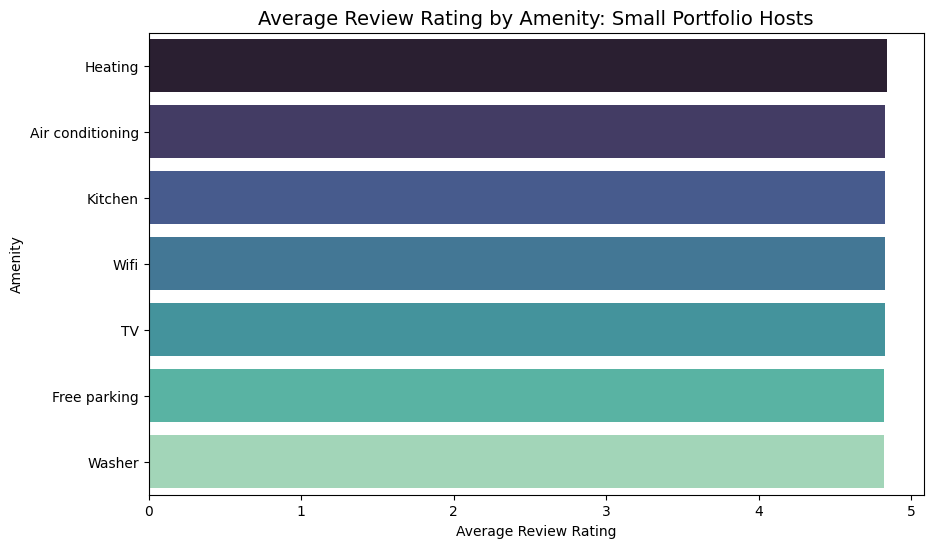

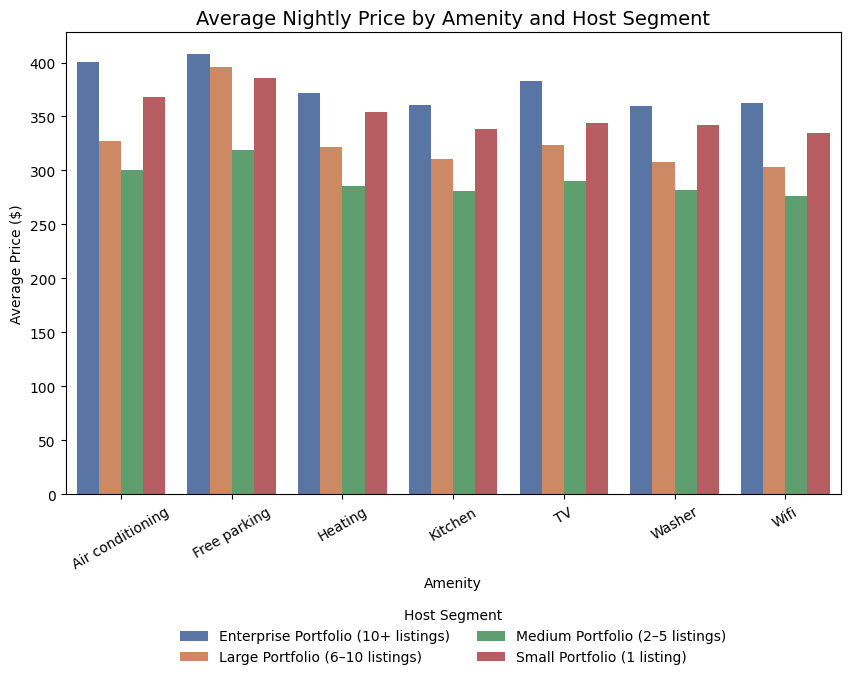

In [46]:
# YOUR CODE GOES HERE - your visualisation must be shown as an output at the end of this cell
# Visualisation 1 – For New Hosts
# Identify which amenities new (small portfolio) hosts should prioritise to achieve high review scores.

new_hosts_df = summary[summary['host_segments'] == 'Small Portfolio (1 listing)']
plt.figure(figsize=(10, 6))
sns.barplot( data=new_hosts_df.sort_values('review_scores_rating', ascending=False),
    x='review_scores_rating',
    y='amenity',
    palette='mako')
plt.title('Average Review Rating by Amenity: Small Portfolio Hosts', fontsize=14)
plt.xlabel('Average Review Rating')
plt.ylabel('Amenity')

# Visualisation 2 – For Existing Hosts
# Compare pricing strategy across host segments to identify optimisation opportunities.

plt.figure(figsize=(10, 6))
sns.barplot( data=summary,
    x='amenity',
    y='price',
    hue='host_segments',
    palette='deep')
plt.title('Average Nightly Price by Amenity and Host Segment', fontsize=14)
plt.xlabel('Amenity')
plt.ylabel('Average Price ($)')
plt.legend(title='Host Segment', bbox_to_anchor=(0.5, -0.22), loc='upper center', ncol=2, frameon=False)
plt.xticks(rotation=30)
plt.show()

### Explanation of Results for Question 4

#### Recommendation 1: For New Hosts Entering the Market
**Insight:**  
The first visualisation highlights that small portfolio hosts (typically new entrants) achieve the highest guest satisfaction scores (~4.83–4.84) when their listings include essential amenities such as **Heating**, **WiFi**, and **Kitchen**.  

**Actionable Recommendation:**  
- New hosts should prioritise essential comfort amenities (Heating, WiFi, Kitchen) before investing in luxury features or aesthetics.  
- These core amenities drive guest satisfaction and positive reviews, which are critical to quickly build credibility and improve search ranking on Airbnb’s platform.  

**Justification:**  
By focusing on these amenities, new hosts can deliver a consistent and reliable experience with minimal investment, helping them establish trust and attract repeat customers early in their hosting journey.

#### Recommendation 2: For Existing Hosts (Medium–Enterprise)
**Insight:**  
From the second chart, larger portfolio hosts command **higher average nightly prices**, especially for listings with *Free Parking* and *Air Conditioning*.  
However, their **review ratings** are slightly lower than smaller hosts, suggesting diminishing personalisation as scale increases.  

**Actionable Recommendation:**  
- Existing **multi-listing** or **Enterprise hosts** should refine pricing strategies and differentiate their listings by quality, not just quantity,  
- They can optimise profitability by analysing amenity-based pricing performance and offering premium experiences tied to those amenities  

**Justification:**  
Strategically enhancing premium comfort amenities enables higher margins, while balancing price with guest satisfaction is key for scalability. Maintaining personalised touches such as clearer communication and improved comfort amenities helps retain high ratings while leveraging operational scale for better revenue efficiency.

# Question 5 (2.5 marks)

Airbnb would like to investigate whether the timing of reviews and the quality of listings impact user engagement. As a data analyst, your task is to verify or challenge the following claim:

“Listings tend to receive more reviews during weekends and public holidays in NSW. Additionally, listings with higher ratings tend to attract more reviews and are managed by hosts with higher response rates.”

**Marking Criteria:**
- [2 marks] The analysis/charts effectively identify trends and patterns.
- [0.5 marks] The visualisation maintains a professional standard of visual quality, clarity, formatting, and correctness.



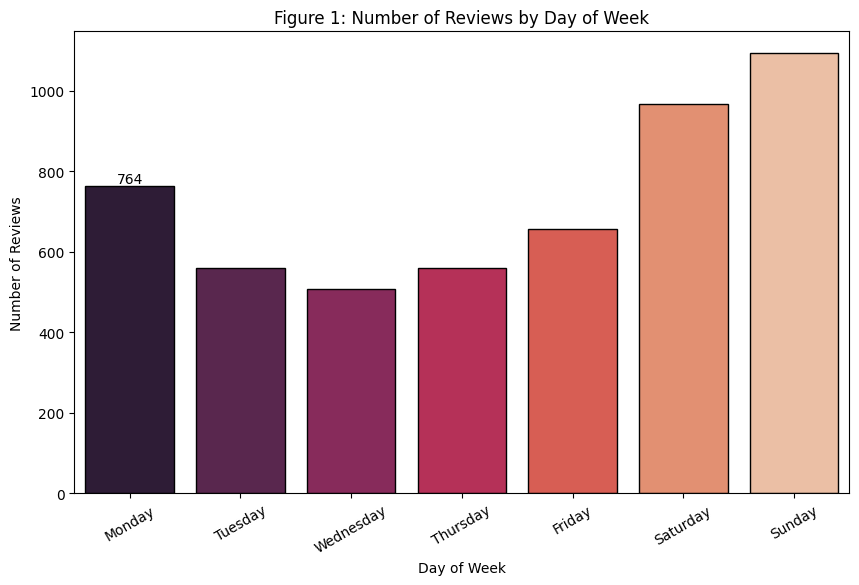

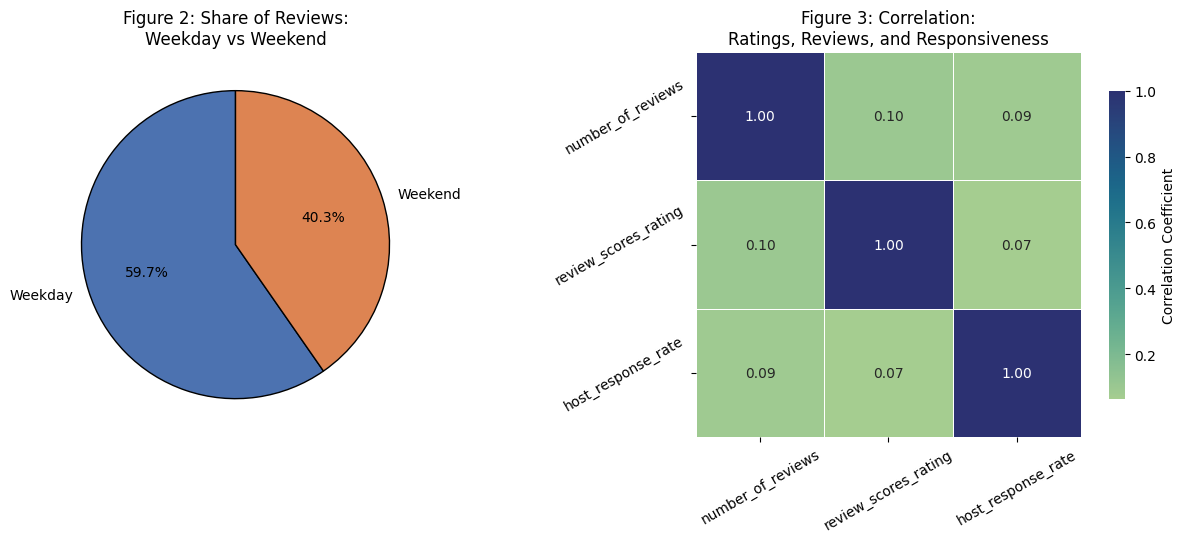

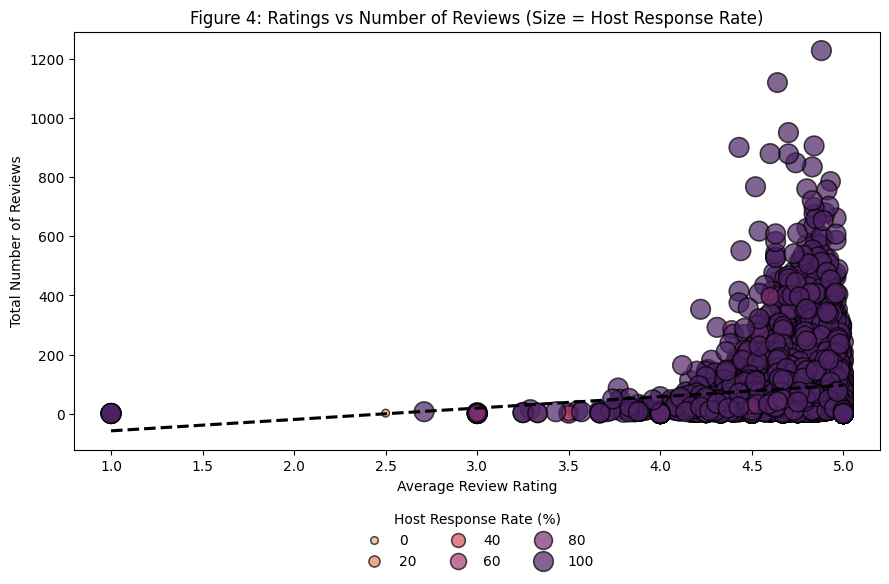

In [47]:
# YOUR CODE GOES HERE - your visualisation must be shown as an output at the end of this cell
# Data Preparation 
merged_df = merged_df.dropna(subset=['date'])
merged_df['date'] = pd.to_datetime(merged_df['date'], errors='coerce')
merged_df['day_of_week'] = merged_df['date'].dt.day_name()
merged_df['is_weekend'] = merged_df['day_of_week'].isin(['Saturday', 'Sunday'])

# Review frequency by day 
reviews_per_day = ( merged_df.groupby('day_of_week')['id']
    .count()
    .reindex(['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'])
    .reset_index(name='num_reviews'))

plt.figure(figsize=(10,6))
ax = sns.barplot(
    data=reviews_per_day, x='day_of_week', y='num_reviews',
    palette='rocket', edgecolor='black'
)
ax.bar_label(ax.containers[0])
plt.title('Figure 1: Number of Reviews by Day of Week')
plt.xlabel('Day of Week')
plt.ylabel('Number of Reviews')
plt.xticks(rotation=30)

reviews_summary = (
    merged_df.groupby('id')
    .agg({
        'number_of_reviews':'first',
        'review_scores_rating':'first',
        'host_response_rate':'first'
    })
    .dropna()
)
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# Weekend vs Weekday Share (Pie Chart)
weekend_share = merged_df['is_weekend'].value_counts(normalize=True).mul(100)
colors = sns.color_palette("deep",2)
axes[0].pie(
    weekend_share,
    labels=['Weekday', 'Weekend'],
    autopct='%1.1f%%',
    startangle=90,
    colors=colors,
    wedgeprops={'edgecolor': 'black'}
)
axes[0].set_title('Figure 2: Share of Reviews:\nWeekday vs Weekend')

# Correlation Heatmap 
sns.heatmap( reviews_summary.corr(),
    annot=True,
    cmap='crest',
    fmt='.2f',
    cbar=True,
    cbar_kws={'shrink': 0.8, 'label': 'Correlation Coefficient'},
    ax=axes[1],
    square=True,
    linewidths=0.5)
axes[1].set_title('Figure 3: Correlation:\nRatings, Reviews, and Responsiveness')
axes[1].set_yticklabels(axes[1].get_yticklabels(), rotation=30)
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=30)


# Scatterplot: Ratings vs Review Count
plt.figure(figsize=(9,6))
sns.scatterplot( data=reviews_summary,
    x='review_scores_rating', y='number_of_reviews',
    size='host_response_rate', hue='host_response_rate',
    palette='flare', alpha=0.7, sizes=(30,200), edgecolor='black')
sns.regplot( data=reviews_summary,
    x='review_scores_rating', y='number_of_reviews',
    scatter=False, color='black', ci=None, line_kws={'linestyle':'--'})

plt.title('Figure 4: Ratings vs Number of Reviews (Size = Host Response Rate)')
plt.xlabel('Average Review Rating')
plt.ylabel('Total Number of Reviews')
plt.legend(title='Host Response Rate (%)', bbox_to_anchor=(0.5, -0.12), loc='upper center', ncol=3, frameon=False)
plt.tight_layout()
plt.show()

### Explanation of Results for Question 5
#### Insight 1: Weekend Review Activity 

**Insight:**
The first chart shows a clear rise in review counts during **Saturdays and Sundays**, with weekends generating the highest number of reviews.
This aligns with user behaviour guests are more likely to complete stays and leave reviews over the weekend or right after short holiday trips, reinforcing Airbnb’s claim about weekend engagement.To further verify holiday spikes, public holiday calendars could be merged with the review dates (e.g., NSW holiday dataset).

**Actionable Recommendation:**
- Airbnb should automatically send review reminders or prompts on weekends, when guests are most responsive.
- This timing-based engagement strategy could significantly increase review rates and visibility for hosts.
 
**Justification:**
The bar and pie charts confirm that nearly 40% of reviews occur on weekends, making it an optimal time for automated follow-ups.
By aligning review requests with natural user behaviour, Airbnb can enhance participation without additional marketing costs

#### Insight 2: Ratings, Reviews, and Host Responsiveness 

**Insight:**
The correlation heatmap and scatterplot reveal that listings with higher ratings and more responsive hosts tend to receive more reviews overall.
Although the correlations are modest (r ≈ 0.1), the trend is consistent, strong communication and service quality subtly boost engagement.

**Actionable Recommendation:**
- Airbnb should incentivise high host responsiveness through badges, performance tiers, or faster-response visibility boosts.
- This encourages quality communication and strengthens guest trust, leading to higher engagement and better ratings.

**Justification:**
Figures 3 & 4 show that high-rated, responsive hosts cluster in high-review zones, confirming that guest satisfaction and communication speed enhance engagement.Promoting host responsiveness strengthens Airbnb’s reputation for reliability and hospitality, improving both review frequency and guest retention.

**Conclusion:**

The results partly validate Airbnb’s claim:
- Review activity is clearly concentrated on weekends, confirming that timing affects user engagement.
- Listings with strong ratings and high host responsiveness receive more reviews, though the correlation is modest.
Together, these insights highlight that timing and service quality jointly influence engagement.
- By optimising review request timing and rewarding responsive hosts, Airbnb can sustainably improve both the quantity and quality of user feedback across its platform.


# Question 6 (3 marks)

Create visualisation(s) to outline notable points to the community about the price distributions in Sydney based on listing and neighbourhood information.


**Marking Criteria:**
- [2.5 marks] The visualisation has depth and relevance to the community about price distributions in Sydney.
- [0.5 marks] The visualisation maintains a professional standard of visual quality, clarity, formatting, and correctness.

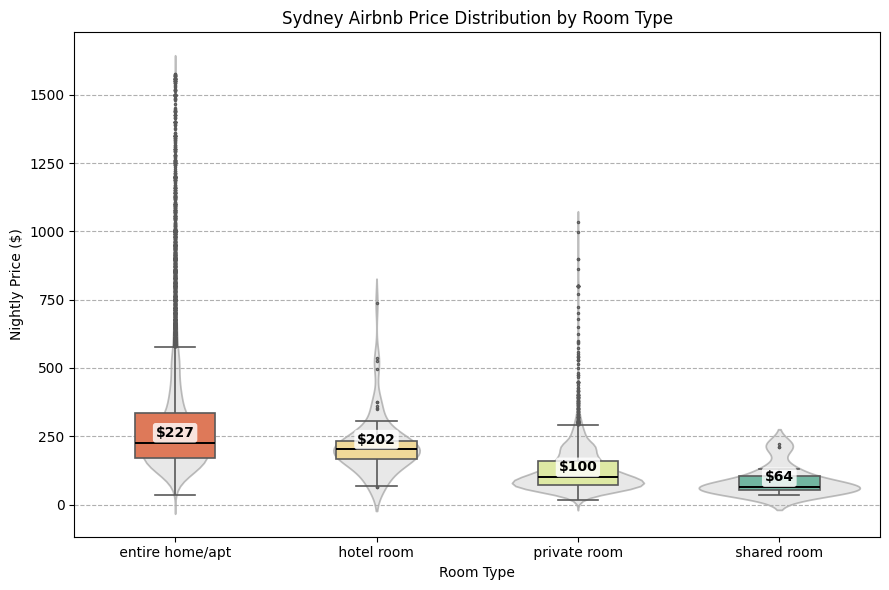

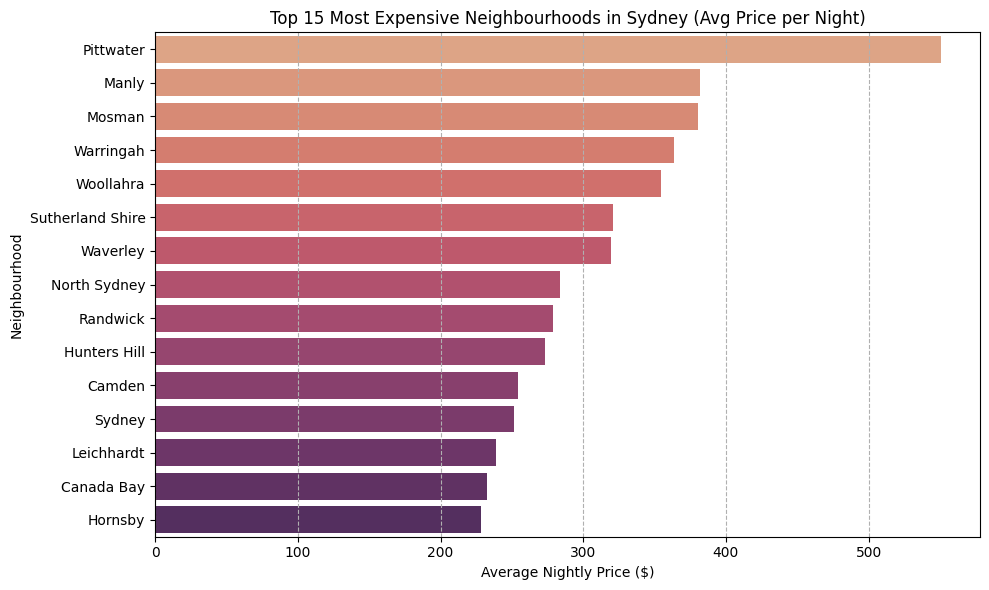

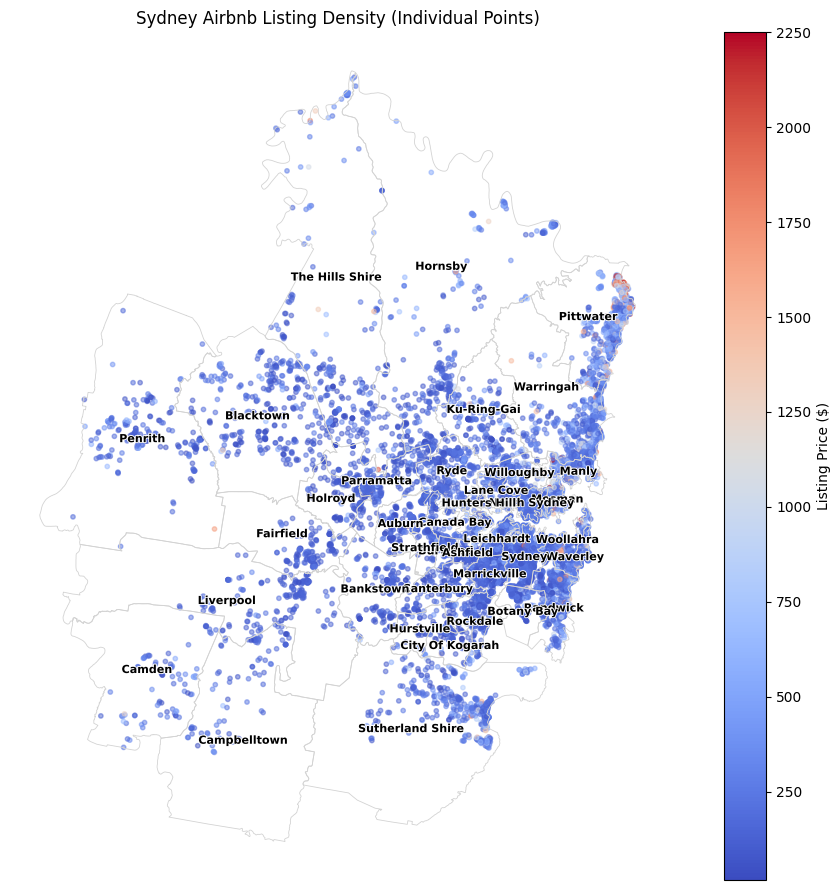

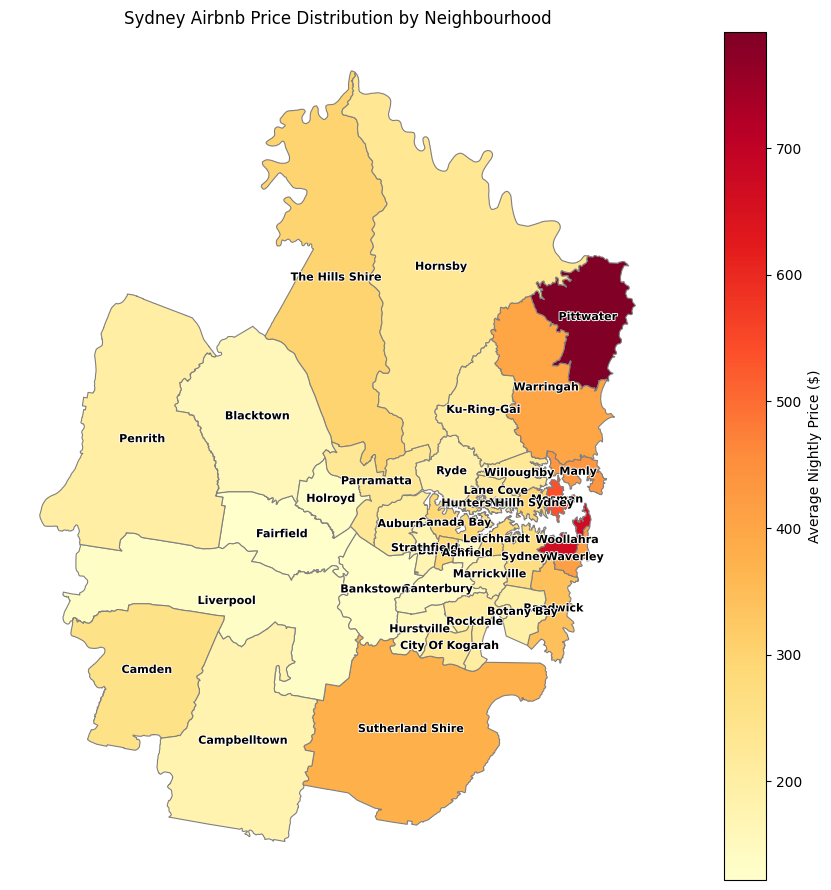

In [48]:
# YOUR CODE GOES HERE - your visualisation must be shown as an output at the end of this cell
# Prepare Geodata
avg_price_geo = (
    listings_df.groupby('neighbourhood_cleansed', as_index=False)['price']
    .mean()
    .rename(columns={'neighbourhood_cleansed': 'neighbourhood'})
)

geo_price_df = neighbourhoods_df.merge(avg_price_geo, on='neighbourhood', how='left')
geo_price_df['centroid'] = geo_price_df.geometry.centroid
geo_price_df['x'] = geo_price_df['centroid'].x
geo_price_df['y'] = geo_price_df['centroid'].y

price_cap = listings_df['price'].quantile(0.99)
scatter_data = listings_df[listings_df['price'] <= price_cap].copy()

listings_gdf = gpd.GeoDataFrame(
    scatter_data,
    geometry=gpd.points_from_xy(scatter_data.longitude, scatter_data.latitude),
    crs=geo_price_df.crs
)

# Price Distribution by Room Type
price_cap = listings_df['price'].quantile(0.98)
price_data = listings_df[listings_df['price'] <= price_cap].copy()

room_order = (
    price_data.groupby('room_type')['price']
    .median()
    .sort_values(ascending=False)
    .index
)

palette = sns.color_palette("Spectral", n_colors=len(room_order))

plt.figure(figsize=(9,6))
sns.violinplot(
    data=price_data,
    x='room_type', y='price',
    inner=None, color='lightgrey',
    order=room_order, alpha=0.5
)

ax = sns.boxplot(
    data=price_data,
    x='room_type', y='price',
    order=room_order, width=0.4,
    palette=palette, fliersize=1.5,
    linewidth=1.2, medianprops={'color': 'black', 'linewidth': 1.4}
)

medians = price_data.groupby('room_type')['price'].median()
for i, room in enumerate(room_order):
    median_val = medians[room]
    ax.text(
        i, median_val + 10, f"${median_val:.0f}",
        ha='center', va='bottom', color='black', weight='bold',
        fontsize=10,
        bbox=dict(facecolor='white', alpha=0.8, edgecolor='none', boxstyle='round,pad=0.2')
    )

plt.title('Sydney Airbnb Price Distribution by Room Type')
plt.xlabel('Room Type')
plt.ylabel('Nightly Price ($)')
plt.grid(axis='y', linestyle='--')
plt.tight_layout()


# Top 15 Most Expensive Neighborhood
avg_price_by_area = (
    price_data.groupby('neighbourhood_cleansed')['price']
    .mean()
    .sort_values(ascending=False)
    .head(15)
    .reset_index()
)

plt.figure(figsize=(10,6))
sns.barplot(
    data=avg_price_by_area,
    x='price', y='neighbourhood_cleansed',
    palette='flare'
)
plt.title('Top 15 Most Expensive Neighbourhoods in Sydney (Avg Price per Night)')
plt.xlabel('Average Nightly Price ($)')
plt.ylabel('Neighbourhood')
plt.grid(axis='x', linestyle='--')
plt.tight_layout()


# MAP 1 – Dot Plot (Individual Listings)
fig, ax = plt.subplots(1, 1, figsize=(12, 9))
geo_price_df.boundary.plot(ax=ax, color='lightgrey', linewidth=0.6)

listings_gdf.plot(
    ax=ax,
    markersize=10,
    alpha=0.5,
    column='price',
    cmap='coolwarm',
    legend=True,
    legend_kwds={'label': "Listing Price ($)", 'orientation': "vertical"}
)
top_labels = geo_price_df.nlargest(40, 'price')
list(map(
    lambda x, y, n: ax.text(
        x, y, n,
        fontsize=8,
        ha='center', va='center',
        color='black',
        weight='bold',
        path_effects=[pe.withStroke(linewidth=1.3, foreground='white')]
    ),
    top_labels['x'], top_labels['y'], top_labels['neighbourhood']
))

ax.set_title("Sydney Airbnb Listing Density (Individual Points)")
ax.set_axis_off()
plt.tight_layout()

# MAP 2 – Chloropleth (Neighbourhood Averages)
fig, ax = plt.subplots(1, 1, figsize=(12, 9))

geo_price_df.plot(
    column='price',
    cmap='YlOrRd',
    linewidth=0.8,
    ax=ax,
    edgecolor='grey',
    legend=True,
    legend_kwds={'label': "Average Nightly Price ($)", 'orientation': "vertical"}
)

# Label top 40 neighbourhoods
top_labels = geo_price_df.nlargest(40, 'price')
list(map(
    lambda x, y, n: ax.text(
        x, y, n,
        fontsize=8,
        ha='center', va='center',
        color='black', weight='bold',
        path_effects=[pe.withStroke(linewidth=1.3, foreground='white')]
    ),
    top_labels['x'], top_labels['y'], top_labels['neighbourhood']
))

ax.set_title("Sydney Airbnb Price Distribution by Neighbourhood")
ax.set_axis_off()
plt.tight_layout()
plt.show()

### Explanation of Results for Question 6
This section visualises Airbnb price distributions across Sydney, integrating geographic, listing-level, and room-type analyses.
The goal is to highlight spatial inequalities, affordability trends, and opportunities for both hosts and the wider community.

#### Price Distribution by Room Type (Violin + Box Plot)
- Entire homes/apartments dominate with a **median ≈ $227/night**, catering to families and groups.
- Hotel rooms average ≈ **$202**, while private rooms (≈ $100) and shared rooms (≈ $64) target budget travellers.
- The violin overlay highlights broad variance within entire homes, capturing both affordable and luxury inventory.

#### Top 15 Most Expensive Neighbourhoods (Bar Chart)
- *Pittwater, Manly, Mosman, Woollahra, and Waverley* dominate Sydney’s premium coastal market.
- *Sutherland Shire and Randwick* offer mid-tier luxury appeal, while Hornsby and Canada Bay represent more accessible urban zones.
- The east–west divide remains evident, driven by geography, amenities, and perceived lifestyle value.

#### Listing Density (Dot Map)
- Listings are **densely clustered** along the eastern coast and CBD corridor, aligning with major tourism and nightlife hubs.
- **Sparse density** west of the Parramatta River highlights growth potential for suburban and regional stays.
- This imbalance suggests an opportunity to **diversify Sydney’s visitor economy** by supporting less-saturated districts.

#### Geographic Pricing Patterns (Choropleth Map)
- **The northern and coastal suburbs** Pittwater, Manly, Mosman, and Woollahra record the highest **nightly prices** (>$500), reflecting premium waterfront demand.
- **Inner-city zones** (Sydney CBD, North Sydney, Randwick) maintain strong mid-to-high pricing due to proximity to transport, jobs, and attractions.
- **Western suburbs** (Parramatta, Blacktown, Penrith) remain budget-friendly, supporting longer stays and family travel.

#### Recommendation to the Community
##### For Residents & Local Councils:
Encourage balanced tourism by promoting mid-range accommodation in western and southern suburbs, easing housing pressure on coastal areas.
Strategic investment in public transport, local attractions, and amenities can redistribute visitor demand and boost local economies.

##### For Airbnb Hosts:
- **Coastal hosts should leverage premium demand with dynamic pricing and off-peak discounts.**
- **New entrants in inland suburbs should focus on affordability and essential amenities (Wi-Fi, kitchen, parking) to capture first-time guests.**

#### Conclusion
Sydney’s Airbnb landscape reveals a distinct spatial and structural segmentation:
Luxury coastal clusters dominate pricing and visibility.
High-density CBD zones balance business and leisure demand.
Outer suburbs remain affordable, offering untapped hosting opportunities.
These insights highlight how understanding neighbourhood context, room type, and host strategy can guide sustainable pricing, equitable tourism planning, and community wellbeing aligning with Airbnb’s mission for inclusive growth across Sydney.